# Проект 4. Компьютер говорит нет

## Бровкин Виктор

# Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.decomposition import PCA
from sklearn.feature_selection import f_classif, mutual_info_classif


from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve, recall_score, precision_score, f1_score, balanced_accuracy_score
 

from itertools import combinations

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

In [2]:
# Зафиксируем RANDOM_SEED, чтобы эксперименты были воспроизводимы:
RANDOM_SEED = 42
# Зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

# Обработка

In [3]:
def outliers_iqr(df, col):
    '''
    функция оценки выбросов
    '''
    perc25, perc75 = np.percentile(df[col], [25, 75])
    iqr = perc75 - perc25
    low = perc25 - (iqr * 1.5)
    high = perc75 + (iqr * 1.5)
    out_cnt = len(df[df[col] > high]) +  len(df[df[col] < low])
    if out_cnt:
        print(f"{col}:  [{perc25}, {perc75}], [{low}, {high}]")
        print(f"    out_cnt:  {out_cnt}")



# Загрузка данных

In [4]:
# DATA_DIR = '/kaggle/input/sf-dst-scoring'
DATA_DIR = '.'
train = pd.read_csv(DATA_DIR + '/train.csv')
test = pd.read_csv(DATA_DIR + '/test.csv')
sample_submission = pd.read_csv(DATA_DIR + '/submission.csv')
train.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [5]:
test.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N


In [6]:
sample_submission.head()

,client_id,default
0,74835,0.035398
1,17527,0.302982
2,75683,0.056655
3,26883,0.095389
4,28862,0.015928


In [7]:
# Объединение в один датасет
train['train'] = 1 
test['train'] = 0 
test['default'] = 0 
# df = test.append(train, sort=False).reset_index(drop=True) 
df = test.append(train)
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,train,default
0,74835,22MAR2014,GRD,M,29,Y,Y,0,0,-2.271884,3,50,1,2,50000,1,4,N,0,0
1,17527,24JAN2014,SCH,F,39,N,N,5,0,-1.504999,2,50,1,2,5000,4,3,N,0,0
2,75683,23MAR2014,UGR,M,50,Y,Y,0,0,-1.691339,1,50,1,2,30000,1,3,Y,0,0
3,26883,03FEB2014,SCH,M,56,N,N,0,0,-2.374182,1,40,1,2,17000,1,3,N,0,0
4,28862,04FEB2014,GRD,F,38,N,N,0,0,-2.487502,0,80,2,3,120000,1,3,N,0,0


# Описание данных

### Датасет состоит из девятнадцати столбцов:
1. client_id: идентификатор клиента;
2. education: уровень образования; 
3. sex: пол заёмщика;
4. age: возраст заёмщика;
5. car: флаг наличия автомобиля;
6. car_type: флаг автомобиля-иномарки;
7. decline_app_cnt: количесвто отказанных прошлых заявок;
8. good_work: флаг наличия "хорошей" работы; 
9. bki_request_cnt: количество запросов в БКИ(Бюро кредитных историй);
10. home_adress: категоризатор домашнего адреса;
11. work_adress: категоризатор рабочего адреса;
12. income: доход заёмщика;
13. foreign_passport: наличие загранпаспорта;
14. sna - связь заемщика с клиентами банка;
15. first_time - давность наличия информации о заемщике;
16. score_bki - скоринговый балл по данным из БКИ;
17. region_rating - рейтинг региона;
18. app_date - дата подачи заявки;
19. default: наличие дефолта;

In [8]:
# проверка на наличие пропусков
for col in df.columns:
    cnt = df[col].isnull().sum()
    if cnt:
        print(f"{col}: {cnt}")


education: 478


In [9]:
# проверка на наличе дубликатов
df[df.duplicated()]


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,train,default


In [10]:
# анализ типов признаков
df.nunique(dropna=False)

client_id           110148
app_date               120
education                6
sex                      2
age                     52
car                      2
car_type                 2
decline_app_cnt         24
good_work                2
score_bki           102618
bki_request_cnt         40
region_rating            7
home_address             3
work_address             3
income                1207
sna                      4
first_time               4
foreign_passport         2
train                    2
default                  2
dtype: int64

0    0.873006
1    0.126994
Name: default, dtype: float64


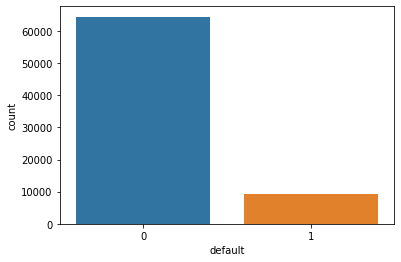

In [11]:
# распределение значений целевого признака
print(df.query('train == 1')['default'].value_counts(normalize=True))
sns.countplot(x=df.query('train == 1')['default']);


## Выводы
* признак default целевая переменная
* признак education имеет пропуски
* признак client_id являтся идентификатором записи и может быть удален
* дубликатов нет
* разпределение целевого признака 88 к 12

## По типам признаки могут быть разбиты на
### Числовые
* client_id           10898
* app_date              120
* age                    50
* decline_app_cnt        12
* score_bki           10360
* bki_request_cnt        28
* income                376
### Категориальные
* education               6
* region_rating           7
* home_address            3
* work_address            3
* sna                     4
* first_time              4
### Бинарные
* sex                     2
* car                     2
* car_type                2
* good_work               2
* foreign_passport        2
* train                   2
* default                 2


# Числовые признаки

In [12]:
num_cols = ['client_id', 'app_date', 'age', 'decline_app_cnt', 'score_bki', 'bki_request_cnt', 'income']
df[num_cols].head()

,client_id,app_date,age,decline_app_cnt,score_bki,bki_request_cnt,income
0,74835,22MAR2014,29,0,-2.271884,3,50000
1,17527,24JAN2014,39,5,-1.504999,2,5000
2,75683,23MAR2014,50,0,-1.691339,1,30000
3,26883,03FEB2014,56,0,-2.374182,1,17000
4,28862,04FEB2014,38,0,-2.487502,0,120000


In [13]:
# удаление client_id
num_cols.remove('client_id')

In [14]:
# app_date
df.app_date.value_counts()[:5]

18MAR2014    1491
19MAR2014    1363
17MAR2014    1350
31MAR2014    1317
07APR2014    1296
Name: app_date, dtype: int64

<AxesSubplot:xlabel='app_date', ylabel='count'>

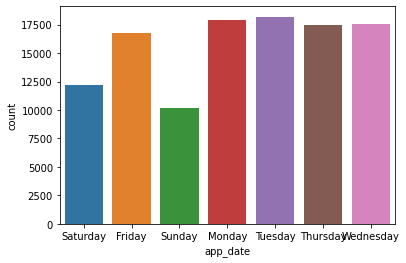

In [15]:
# преобразование и просмотр распределения
df['app_date'] = pd.to_datetime(df['app_date'])
sns.countplot(x=df['app_date'].dt.day_name())

In [16]:
# Дата подачи заявки равномерно распределена по дням недели и вероятно не влияет на целевую перемунную
# удаление признака
num_cols.remove('app_date')

In [17]:
# анализ выбросов
for col in num_cols:
    outliers_iqr(df.query('train == 1'), col)


decline_app_cnt:  [0.0, 0.0], [0.0, 0.0]
    out_cnt:  12585
score_bki:  [-2.259533835, -1.56983126], [-3.2940876975, -0.5352773974999998]
    out_cnt:  351
bki_request_cnt:  [0.0, 3.0], [-4.5, 7.5]
    out_cnt:  1755
income:  [20000.0, 48000.0], [-22000.0, 90000.0]
    out_cnt:  4695


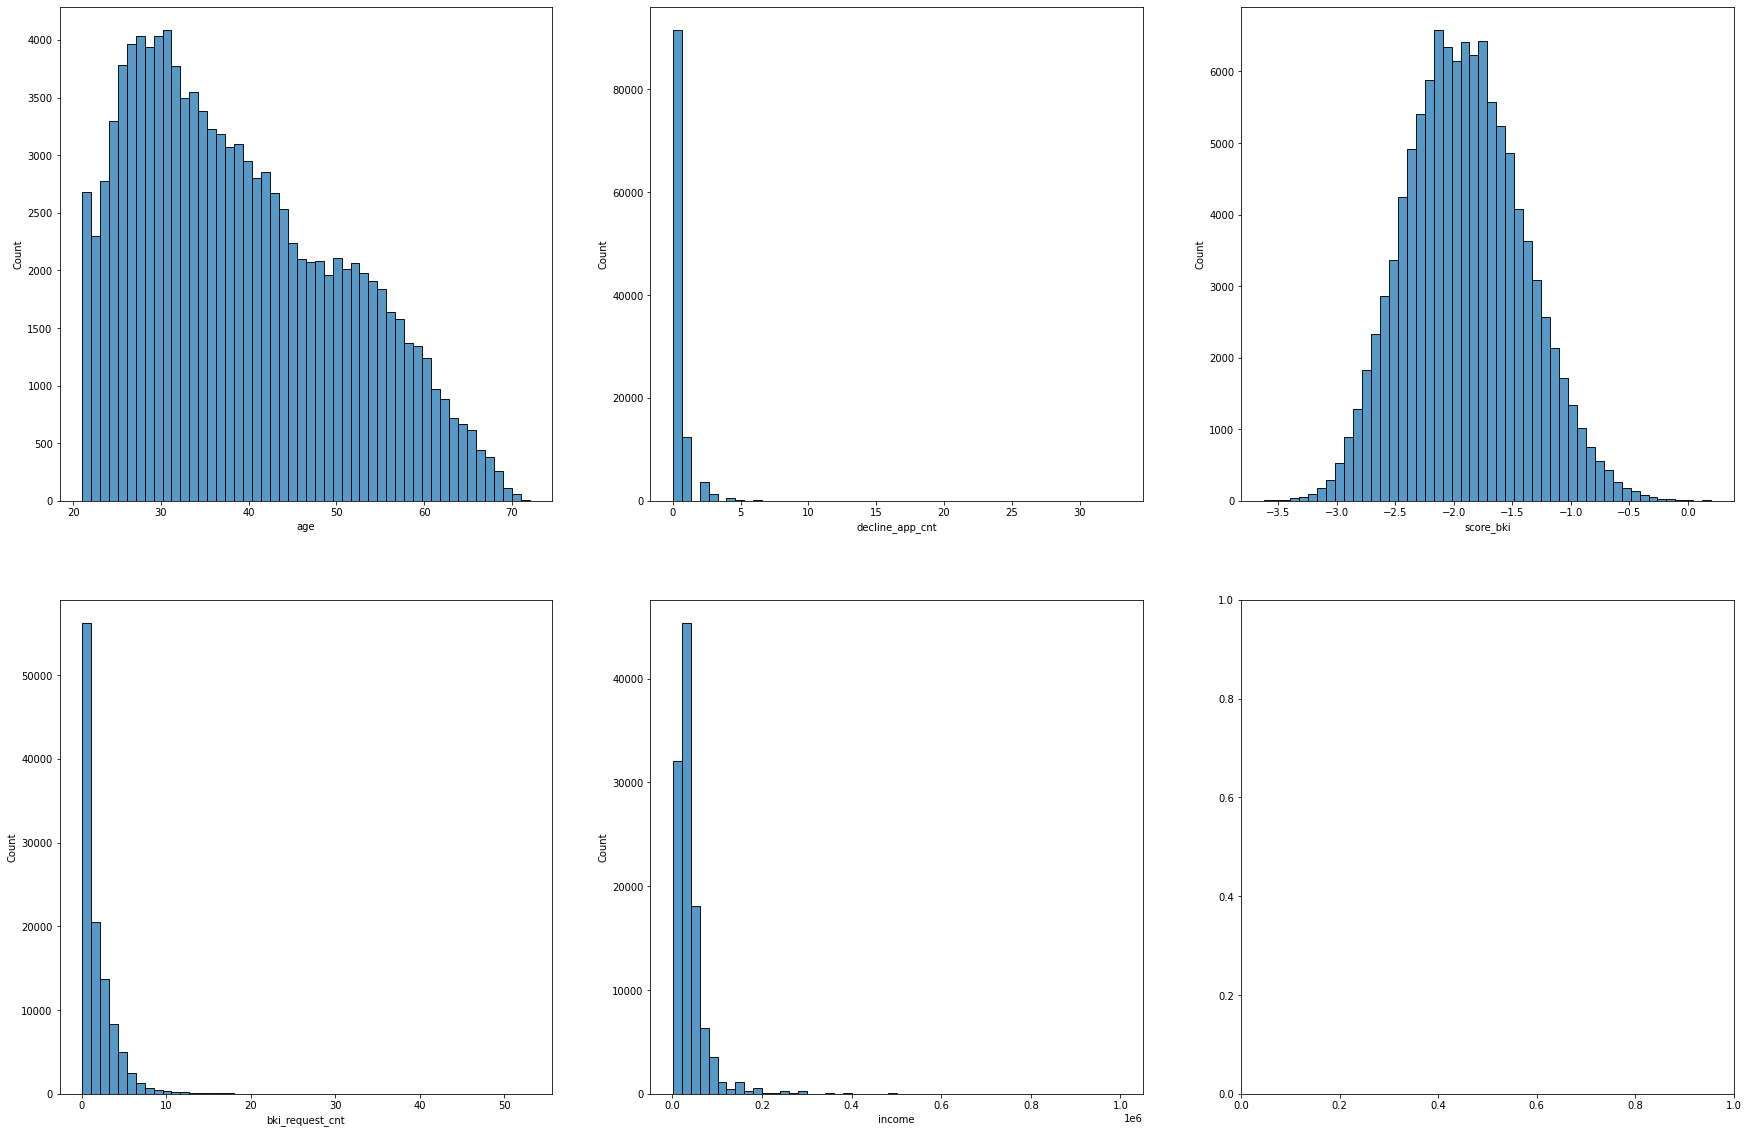

In [19]:
# распределения числовых признаков:
fig, axes = plt.subplots(2, 3, figsize=(30,20))
for i,col in enumerate(num_cols):
    sns.histplot(df[col], ax=axes.flat[i], bins=50, kde_kws={'bw': 0.55})

In [1]:
# матрица корреляции
f = plt.subplots(figsize=(10, 8))
sns.heatmap(df[num_cols].corr().abs(), vmin=0,
            vmax=1, annot=True, fmt=".2f", linewidths=0.1);


NameError: name 'plt' is not defined

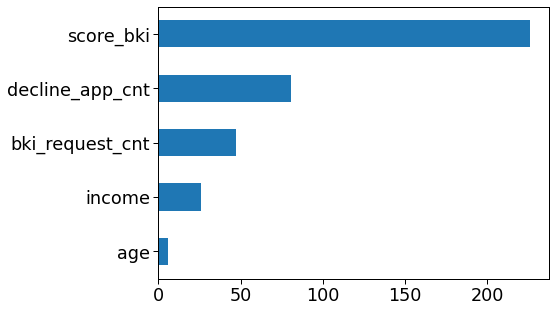

In [ ]:

# Определим значимость числовых признаков с помощью функции mutual_info_classif:
fig = plt.subplots(figsize=(7, 5))
imp_num = pd.Series(f_classif(df.query('train == 1')[num_cols], df.query('train == 1')['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh');

# Категориальные признаки

In [ ]:
cat_cols = ['education', 'region_rating', 'home_address', 'work_address', 'sna', 'first_time']
df[cat_cols].head()

,education,region_rating,home_address,work_address,sna,first_time
0,GRD,50,1,2,1,4
1,SCH,50,1,2,4,3
2,UGR,50,1,2,1,3
3,SCH,40,1,2,1,3
4,GRD,80,2,3,1,3


In [ ]:
df['education'].value_counts()

SCH    5688
GRD    3484
UGR    1484
PGR     173
ACD      25
Name: education, dtype: int64

In [ ]:
# заполнение пустых значений и привдение в числовой формат
df['education'] = df['education'].fillna('SCH')
tmp = df['education'].value_counts().to_dict()
for i, k in enumerate(tmp):
    tmp[k] = i
df['education'] = df['education'].map(tmp).astype('int8')
df['education'].value_counts()

0    5732
1    3484
2    1484
3     173
4      25
Name: education, dtype: int64

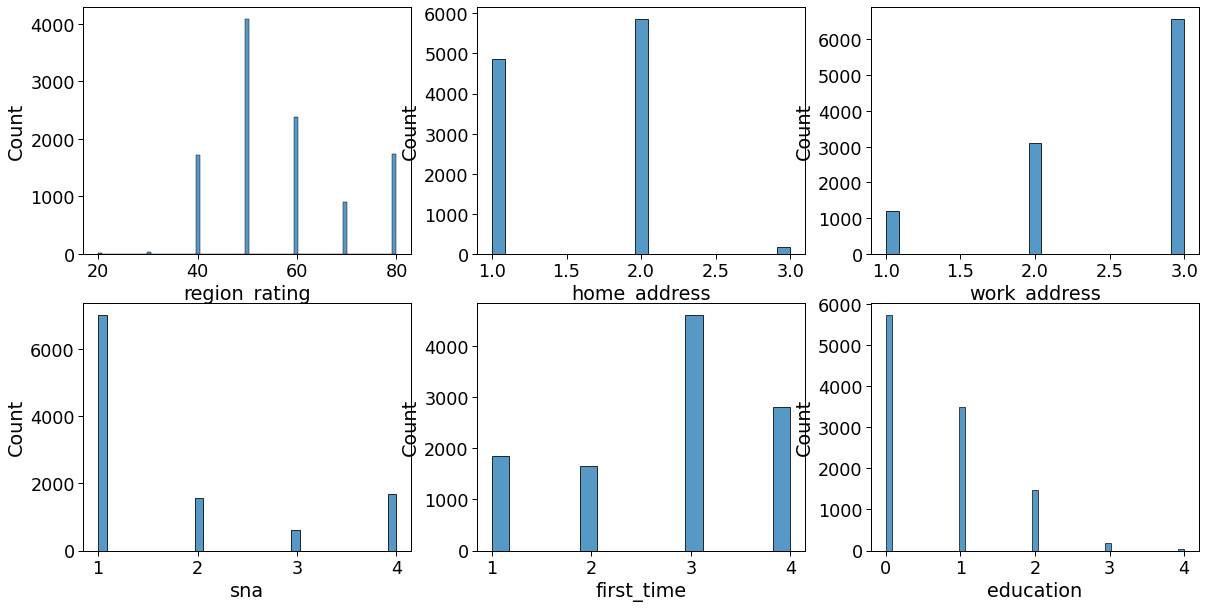

In [ ]:
# распределения категориальных признаков
fig, axes = plt.subplots(2, 3, figsize=(20,10))
for i,col in enumerate(cat_cols):
    sns.histplot(df[col], ax=axes.flat[i-1]);

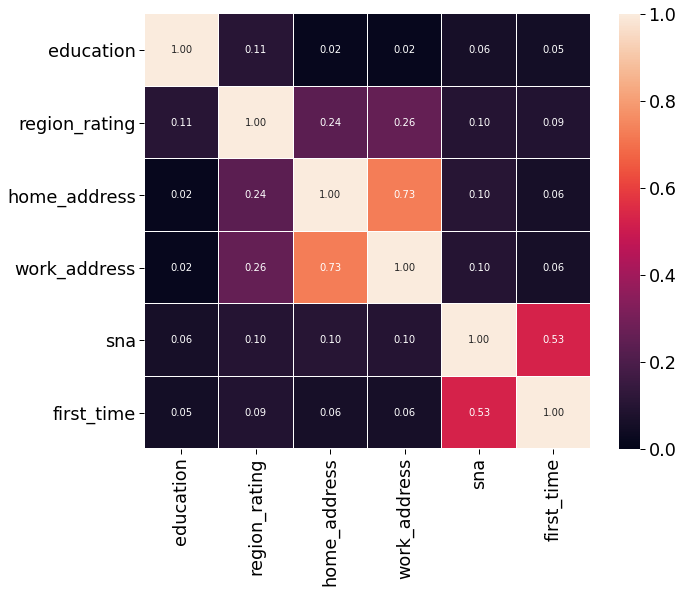

In [ ]:
# матрицf корреляций для категориальных признаков:
f = plt.subplots(figsize=(10, 8))
sns.heatmap(df[cat_cols].corr().abs(), vmin=0,
            vmax=1, annot=True, fmt=".2f", linewidths=0.1);

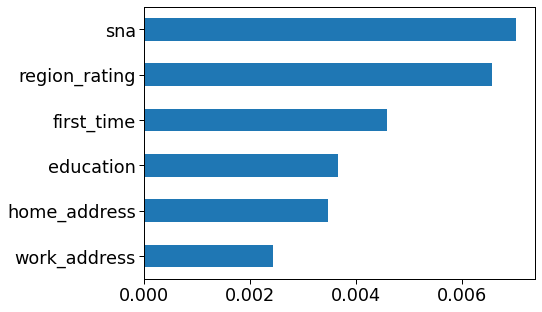

In [ ]:
# значимость категориальных признаков с помощью функции mutual_info_classif
fig = plt.subplots(figsize=(7, 5))
imp_cat = pd.Series(mutual_info_classif(df.query('train == 1')[cat_cols], df.query('train == 1')['default'],
                                        discrete_features=True), index=cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh');

In [ ]:
# в связи с нихой значемостью и высокой корреляцией с home_address удалим work_address
cat_cols.remove('work_address')

# Бинарные признаки

In [ ]:
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']
df[bin_cols].head()

,sex,car,car_type,good_work,foreign_passport
0,M,Y,Y,0,N
1,F,N,N,0,N
2,M,Y,Y,0,Y
3,M,N,N,0,N
4,F,N,N,0,N


In [ ]:
# кодировка бинарных признаков
le = LabelEncoder()
for col in bin_cols:
    df[col] = le.fit_transform(df[col])
    print(dict(enumerate(le.classes_)))

df[bin_cols].head()

{0: 'F', 1: 'M'}
{0: 'N', 1: 'Y'}
{0: 'N', 1: 'Y'}
{0: 0, 1: 1}
{0: 'N', 1: 'Y'}


,sex,car,car_type,good_work,foreign_passport
0,1,1,1,0,0
1,0,0,0,0,0
2,1,1,1,0,1
3,1,0,0,0,0
4,0,0,0,0,0


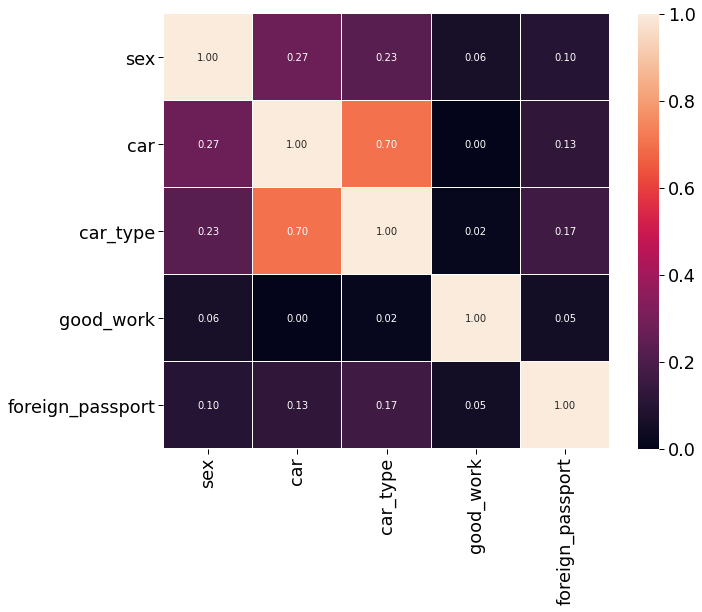

In [ ]:
# матрица корреляций
f = plt.subplots(figsize=(10, 8))
sns.heatmap(df[bin_cols].corr().abs(), vmin=0,
            vmax=1, annot=True, fmt=".2f", linewidths=0.1);

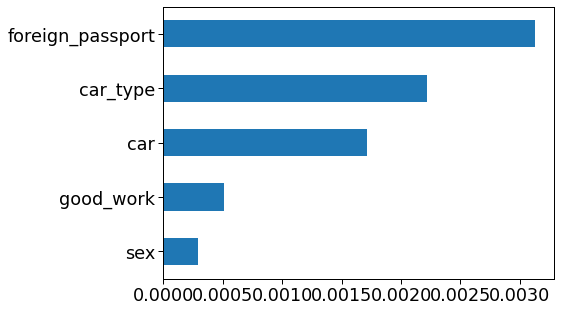

In [ ]:
# оценка значимости бинарных признаков 
fig = plt.subplots(figsize=(7, 5))
bin = pd.Series(mutual_info_classif(df.query('train == 1')[bin_cols], df.query('train == 1')['default'],
                                        discrete_features=True), index=bin_cols)
bin.sort_values(inplace=True)
bin.plot(kind='barh');

In [ ]:
# в связи с нихой значемостью и высокой корреляцией с car_type удалим car
bin_cols.remove('car')

# Подготовка к обучению

In [ ]:
# разбиение датасета на исходные
train = df.query('train == 1').drop(['train'], axis=1)
test = df.query('train == 0').drop(['train', 'default'], axis=1)

In [ ]:
#  массив числовых признаков 
standart_scaler = StandardScaler()
X_train_num = standart_scaler.fit_transform(train[num_cols])
X_test_num = standart_scaler.fit_transform(test[num_cols])
print(X_train_num.shape, X_test_num.shape)

(7299, 5) (3599, 5)


In [ ]:
# массив категориальных признаков 
ohe = OneHotEncoder(sparse=False).fit(df[cat_cols])
X_train_cat = ohe.transform(train[cat_cols])
X_test_cat = ohe.transform(test[cat_cols])
print(X_train_cat.shape, X_test_cat.shape)

(7299, 23) (3599, 23)


In [ ]:
# массив бинарных признаков
X_train_bin = train[bin_cols].values
X_test_bin = test[bin_cols].values
print(X_train_bin.shape, X_test_bin.shape)

(7299, 4) (3599, 4)


In [ ]:
# объединение тестовой выборки
X_test = np.hstack([X_test_num, X_test_cat,  X_test_bin])
X_test.shape

(3599, 32)

In [ ]:
# объединение тренировочной выборки 
X = np.hstack([X_train_num, X_train_cat,  X_train_bin])
y = train['default'].values
print(X.shape, y.shape)

(7299, 32) (7299,)


In [ ]:
# разбивка данных на тренировочные и валидационные
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.70, random_state=RANDOM_SEED)
print(X_train.shape, X_val.shape)

(5109, 32) (2190, 32)


# Обучение

In [ ]:
train_model = LogisticRegression()
train_model.fit(X_train, y_train)

y_pred = train_model.predict(X_val)
y_pred_proba = train_model.predict_proba(X_val)

print('balanced_accuracy_score: %0.3f' % balanced_accuracy_score(y_val, y_pred))
print('precision_score: %0.3f' % precision_score(y_val, y_pred))
print('recall_score: %0.3f' % recall_score(y_val, y_pred))
print('f1_score: %0.3f' % f1_score(y_val, y_pred))
print('roc_auc_score: %0.5f' % roc_auc_score(y_val, y_pred_proba[:, 1]))
fpr, tpr, threshold = roc_curve(y_val, y_pred_proba[:, 1])

balanced_accuracy_score: 0.512
precision_score: 0.471
recall_score: 0.028
f1_score: 0.053
roc_auc_score: 0.72505


/home/eos/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


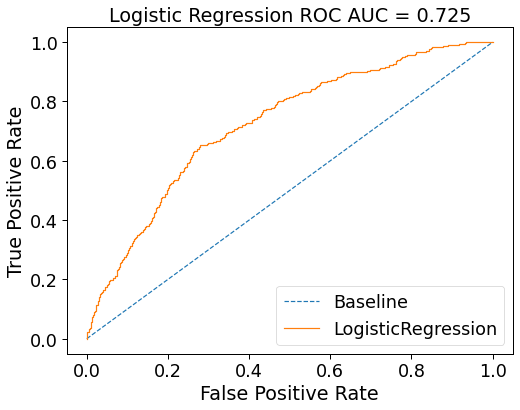

In [ ]:
# Визаулизация ROC AUC:
fig = plt.subplots(figsize=(8, 6))
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'LogisticRegression')
plt.title(f'Logistic Regression ROC AUC = {roc_auc_score(y_val, y_pred_proba[:, 1]):0.3f}')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right');

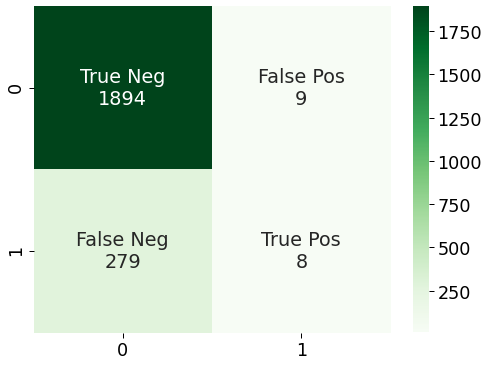

In [ ]:
# Confusion matrix:
fig = plt.subplots(figsize=(8, 6))
sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(y_val, y_pred).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(confusion_matrix(y_val, y_pred), annot=labels, fmt='', cmap='Greens');

In [ ]:
# регуляризация

C = np.logspace(0, 4, 10)
penalty = ['l1', 'l2']
hyperparameters = dict(C=C, penalty=penalty)

train_model = LogisticRegression(solver='liblinear', max_iter=1000)
train_model.fit(X_train, y_train)

clf = GridSearchCV(train_model, hyperparameters, cv=5, verbose=0)

best_train_model = clf.fit(X_train, y_train)
best_penalty =  best_train_model.best_estimator_.get_params()['penalty']
best_C = best_train_model.best_estimator_.get_params()['C']


In [ ]:
train_model = LogisticRegression(solver='liblinear', penalty=best_penalty, C=best_C, max_iter=1000)
train_model.fit(X_train, y_train)

y_pred = train_model.predict(X_val)
y_pred_proba = train_model.predict_proba(X_val)

print('balanced_accuracy_score: %0.3f' % balanced_accuracy_score(y_val, y_pred))
print('precision_score: %0.3f' % precision_score(y_val, y_pred))
print('recall_score: %0.3f' % recall_score(y_val, y_pred))
print('f1_score: %0.3f' % f1_score(y_val, y_pred))
print('roc_auc_score: %0.5f' % roc_auc_score(y_val, y_pred_proba[:, 1]))
fpr, tpr, threshold = roc_curve(y_val, y_pred_proba[:, 1])

balanced_accuracy_score: 0.508
precision_score: 0.400
recall_score: 0.021
f1_score: 0.040
roc_auc_score: 0.72528


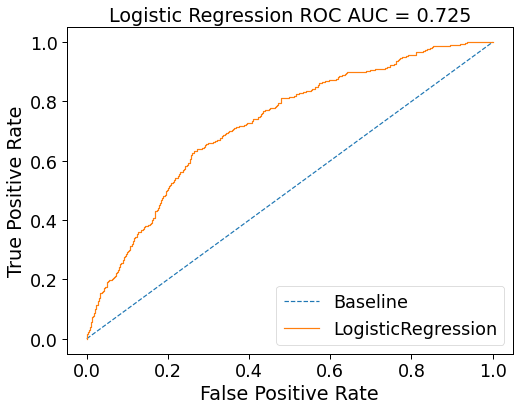

In [ ]:
fig = plt.subplots(figsize=(8, 6))
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'LogisticRegression')
plt.title(f'Logistic Regression ROC AUC = {roc_auc_score(y_val, y_pred_proba[:, 1]):0.3f}')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right');

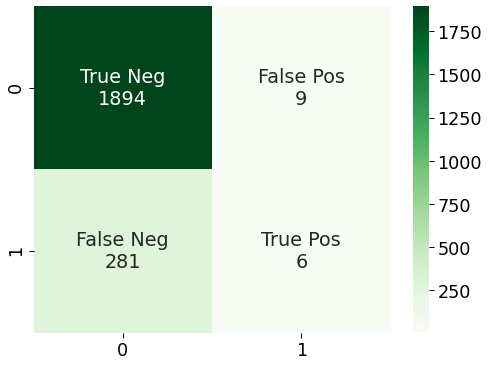

In [ ]:
# Confusion matrix:
fig = plt.subplots(figsize=(8, 6))
sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(y_val, y_pred).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(confusion_matrix(y_val, y_pred), annot=labels, fmt='', cmap='Greens');

In [ ]:
test['default'] = train_model.predict_proba(X_test)[:, 1]
submission = test[['client_id', 'default']]
submission.to_csv('submission.csv', index=False)